In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
import root_pandas as rpd
from root_pandas import read_root

mpl.rcParams.update({'font.size': 18})
mpl.rcParams.update({'legend.fontsize': 20})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})

colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'

Welcome to JupyROOT 6.22/06


# Function definition to extract the ratios

In [2]:
def getRatio(df_A,df_D,df_trigger_A,df_trigger_D, variable='h2_z',trig_cut = 'h1_z>0.5', pair_cut='',minz=0.05,
             maxz=0.5,nbins=9, applyweight=False):
    print ('Print Trigger Cut ' ,trig_cut)
    print ('Total Cut ', trig_cut + pair_cut)
    norm_A = df_trigger_A.query(trig_cut).shape[0] 
    norm_D = df_trigger_D.query(trig_cut).shape[0]
    bins= np.linspace(minz,maxz,nbins)
    y_A, x_conditional = np.histogram(df_A.query(trig_cut+pair_cut)[variable],bins=bins)
    y_D, x_conditional = np.histogram(df_D.query(trig_cut+pair_cut)[variable],bins=bins)
    erry_A, x_conditional = np.histogram(df_A.query(trig_cut+pair_cut)[variable],bins=bins)
    erry_D, x_conditional = np.histogram(df_D.query(trig_cut+pair_cut)[variable],bins=bins)
    x_conditional = (x_conditional[1:] + x_conditional[:-1])/2.0
    err_A = np.true_divide(np.sqrt(erry_A),y_A)
    err_D = np.true_divide(np.sqrt(erry_D),y_D)
    y_A = np.true_divide(y_A,norm_A)
    y_D = np.true_divide(y_D,norm_D)
    ratio_conditional = np.true_divide(y_A,y_D)
    error_conditional = np.multiply(ratio_conditional, np.sqrt(np.power(err_A,2.0) + np.power(err_D,2.0)))
    return ratio_conditional,error_conditional,x_conditional



# Definition of functions related to the cuts applied

In [3]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = None
    if nbeforecut>0:
        cutDataframe = inputDataframe.query(cut)
        if text:
            print (text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)')
    return cutDataframe

def applyCuts(fullDataframe,name='default',isMC=False,isTrigger=True): 
    dataframe = fullDataframe
    if(dataframe.shape[0]>0):
        print ('Entries before cut ', dataframe.shape[0])
    dataframe.eval('inelasticity = nu/5.014', inplace=True)
    dataframe.eval('h1_e = h1_z*nu', inplace=True)
    dataframe.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    dataframe = applyCut(dataframe, 'Q2>1.0', 'Q2>1.0 :')
    #dataframe = applyCut(dataframe, 'Nu>3.0 and Nu<3.5', '3.0 < Nu < 3.5')
    #dataframe = applyCut(dataframe, 'h_z>0.5', 'h_z>0.5 :')
    dataframe = applyCut(dataframe, 'h1_p <2.5 ', 'h1_p<2.5 ')
    dataframe = applyCut(dataframe, 'inelasticity<0.85','inelasticity < 0.85')
    dataframe = applyCut(dataframe, 'abs(h1_pid)==211', 'h1_pid = pions (trigger)')
    return dataframe

def applyCutsPair(fullDataframe,name='default',isMC=False):
    print ('Starting election on dipion variables')
    if (isMC):
        print ('This is MC')
    else: 
        print ('This is Data')
    
    dataframe = fullDataframe
    dataframe.eval('z_tot = h1_z+ h2_z', inplace=True)
    dataframe.eval('h1_e = h1_z*nu', inplace=True)
    dataframe.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    dataframe.eval('h2_e = h2_z*nu', inplace=True)
    dataframe.eval('h2_p = sqrt(h2_e*h2_e-0.13957*0.13957)', inplace=True)
    dataframe = applyCut(dataframe, 'Q2>1.0', 'Q2>1.0 :')
    #dataframe = applyCut(dataframe, 'nu>3.0 and nu<3.5', '3.0 < nu < 3.5')
    dataframe = applyCut(dataframe, 'h1_z>0.5', 'h1_z>0.5 :')
    dataframe = applyCut(dataframe, 'h1_p<2.5', 'h1_p<2.5 GeV ')
    dataframe = applyCut(dataframe, 'h2_p<2.5', 'h2_p<2.5 GeV')
    #dataframe = applyCut(dataframe, 'h1_pid*h2_pid<0', 'Opposite sign pairs')
    dataframe.eval('pair_pt2 = pair_pt*pair_pt', inplace=True)
    dataframe = applyCut(dataframe, 'abs(h2_pid)==211', 'secondary hadrons are pions') 
    dataframe = applyCut(dataframe, 'h2_p>0.2', 'h2_p>0.2')
    dataframe = applyCut(dataframe, 'h1_p>0.2', 'h1_p>0.2')
    
    ## Theta cuts are not applied in the GiBUU case
    if (not isMC):
        dataframe = applyCut(dataframe, 'h2_th<120 and h2_th>10', '10<h2_th<120')
        dataframe = applyCut(dataframe, '(h2_pid==211) | (h2_pid==-211 & h2_th>25 & h2_th<90) | (h2_pid==-211 & h2_th<40 & h2_th>25 & h2_p>0.5)','Theta/P fiducial region selected')
        dataframe = applyCut(dataframe, 'h1_th<120 and h1_th>10', '10< h1_th<120')
        dataframe = applyCut(dataframe, '(h1_pid==211) | (h1_pid==-211 & h1_th>25 & h1_th<90) | (h1_pid==-211 & h1_th<40 & h1_th>25 & h1_p>0.5)','Theta/P fiducial region selected for trigger')
    return dataframe

def printPairBreakdown(dataframe):
    allpairs = 1.0*dataframe.shape[0]
    print ('All pairs ', allpairs)
    print ('Pairs with Leading pi+', np.true_divide(dataframe.query('h1_pid==211').shape[0],allpairs))
    print ('Pairs with Leading pi-', dataframe.query('h1_pid==-211').shape[0]/allpairs)
    print ('Pairs with Sub-Leading pi+', dataframe.query('h2_pid==211').shape[0]/allpairs)
    print ('Pairs with Sub-Leading pi-', dataframe.query('h2_pid==-211').shape[0]/allpairs)
    print ('pi+ pi+ pairs',dataframe.query('h1_pid==211 and h2_pid==211').shape[0]/allpairs)
    print ('pi- pi- pairs',dataframe.query('h1_pid==-211 and h2_pid==-211').shape[0]/allpairs)
    print ('pi+ pi- pairs',dataframe.query('h1_pid==211 and h2_pid==-211').shape[0]/allpairs)
    print ('pi- pi+ pairs',dataframe.query('h1_pid==-211 and h2_pid==211').shape[0]/allpairs)
    print ('//////////////////////////////////////////////////////')
    return


# Get data from Ntuples to dataframes

In [4]:
#this needs to be read in chunks otherwise it uses all memory. (from https://github.com/scikit-hep/root_pandas)
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    for df in read_root(filename, treename, chunksize=100000) :
        #print df.shape[0]
        dataframe = pd.concat([dataframe,df], ignore_index=True) 
    print (dataframe.shape[0])
    return dataframe

# Getting Data

In [5]:
%%time
df = {}
df_trigger = {}
path_data="/home/seba/CreatePairTuples"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df[target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df['D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), '%s_trigger'%target)
    df_trigger['D_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s_trigger'%target)

Getting dataframes from target C
1079080
932821
Get trigger dataframes from deuterium target C
2087382
2294598
Getting dataframes from target Fe
1865381
1356443
Get trigger dataframes from deuterium target Fe
3247856
3394111
Getting dataframes from target Pb
817626
1414899
Get trigger dataframes from deuterium target Pb
1435474
3525405
CPU times: user 33.8 s, sys: 4.37 s, total: 38.1 s
Wall time: 38.1 s


# Getting MC

In [6]:
%%time
df_mc = {}
df_mc_trigger = {}
path_mc="/home/seba/CreatePairTuples"

for target in ['C','D', 'Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df_mc[target]=getdatainChunks('%s/MC_Pairs_%s.root'%(path_mc,target), target)
    df_mc_trigger['%s_trigger'%target] = getdatainChunks('%s/MC_Pairs_%s.root'%(path_mc,target), '%s_trigger'%target)

Getting dataframes from target C
2153884
6089605
Getting dataframes from target D
2196429
6209074
Getting dataframes from target Fe
1993584
5655162
Getting dataframes from target Pb
2099739
5957337
CPU times: user 1min 11s, sys: 31.9 s, total: 1min 42s
Wall time: 1min 42s


Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid',
       'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt',
       'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'x', 'u',
       'h1_ph', 'h1_th', 'h2_ph', 'h2_th'],
      dtype='object')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc342ccef40>,
      dtype=object)

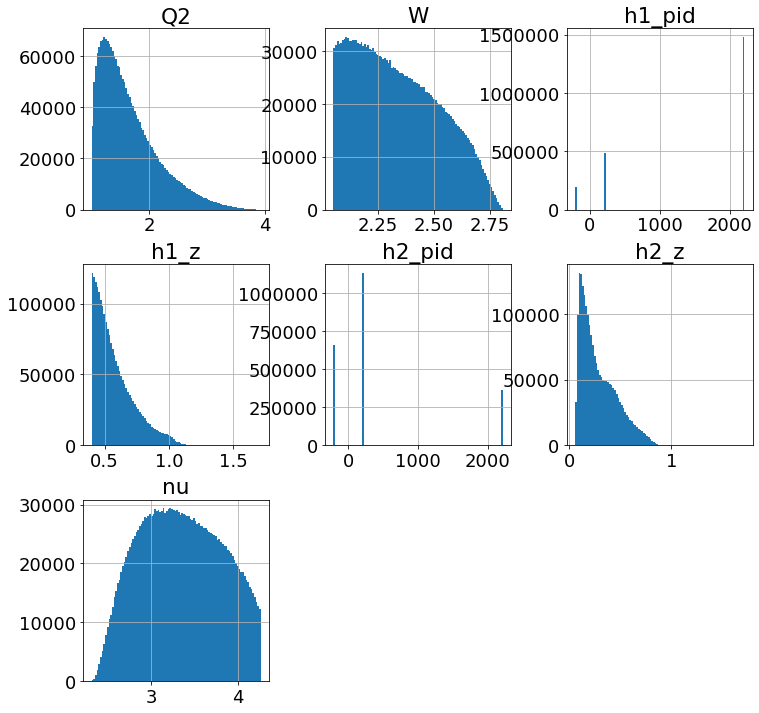

In [7]:
print(df_mc['C'].keys())
df_mc['C'].hist(figsize=(12,12),bins=100,column=['nu','W','Q2','h2_pid', 'h1_pid','h1_z', 'h2_z'])


# Getting GiBUU

In [8]:
%%time

pathGIBUU="/home/miguel/eg2dihadron/"
for target in ['D','C','Fe','Pb']:
    #GiBUU
    print (target)
    print (' trigger')
    df_trigger['GiBUU_%s_trigger'%target]= getdatainChunks('%sGiBUU_Pairs_%s.root'%(pathGIBUU,target), '%s_trigger'%target)
    print (' pairs')
    df['GiBUU_%s'%target]= getdatainChunks('%sGiBUU_Pairs_%s.root'%(pathGIBUU,target), target)
print (df.keys())

D
 trigger
2047709
 pairs
2099630
C
 trigger
2011729
 pairs
2226123
Fe
 trigger
874492
 pairs
1014645
Pb
 trigger
999262
 pairs
1148422
dict_keys(['C', 'D_C', 'Fe', 'D_Fe', 'Pb', 'D_Pb', 'GiBUU_D', 'GiBUU_C', 'GiBUU_Fe', 'GiBUU_Pb'])
CPU times: user 27 s, sys: 7.41 s, total: 34.4 s
Wall time: 34.4 s


In [ ]:
print (df['GiBUU_Fe'].keys())
df['GiBUU_Fe'].eval('Xb=Q2/(2*0.938272*nu)', inplace=True)
df['GiBUU_Fe'].hist(figsize=(12,12),bins=100,column=['Xb','nu','W','Q2','h2_pid', 'h1_pid','h1_z', 'h2_th'])
#plt.show()

# Combine the D2 data-sets

In [ ]:
#df['D'] = df['D_Fe']
#df_trigger['D_trigger'] = df_trigger['D_Fe_trigger']
 #df['D'] = pd.concat([df['D_Fe']) #simply combine the deuterium results for all targets
#df_trigger['D_trigger'] = pd.concat([df_trigger['D_Fe_trigger']]) #simply combine the deuterium results for all targets

#print (df.keys())
#print(df['Fe'].keys())
#print(df_trigger['Fe_trigger'].keys())
## this is just to notice that there are no vectors in the variables, all of them are numbers
#print(df['Fe'].describe())
#print('there are ',len(df['Fe']), 'entries')

watching some distributions

In [ ]:
#df['Fe'].hist(figsize=(12,12),bins=100,column=['dphi','dphi_lab','h2_cm_th','h2_pid'])
#plt.show()

# Apply selection to datasets

In [9]:
%%time
for key in df.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    df[key] = applyCuts(df[key],isMC=isMC)
    df[key] = applyCutsPair(df[key],isMC=isMC)


key:  C
Entries before cut  1079080
Q2>1.0 : 1079080  (100.00  %)
h1_p<2.5  1013790  (93.95  %)
inelasticity < 0.85 1013790  (100.00  %)
h1_pid = pions (trigger) 184608  (18.21  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 184608  (100.00  %)
h1_z>0.5 : 79240  (42.92  %)
h1_p<2.5 GeV  79240  (100.00  %)
h2_p<2.5 GeV 79184  (99.93  %)
secondary hadrons are pions 37460  (47.31  %)
h2_p>0.2 37460  (100.00  %)
h1_p>0.2 37460  (100.00  %)
10<h2_th<120 37460  (100.00  %)
Theta/P fiducial region selected 37460  (100.00  %)
10< h1_th<120 37460  (100.00  %)
Theta/P fiducial region selected for trigger 37460  (100.00  %)

key:  D_C
Entries before cut  932821
Q2>1.0 : 932821  (100.00  %)
h1_p<2.5  857087  (91.88  %)
inelasticity < 0.85 857087  (100.00  %)
h1_pid = pions (trigger) 226104  (26.38  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 226104  (100.00  %)
h1_z>0.5 : 101531  (44.90  %)
h1_p<2.5 GeV  101531  (100.00  %)
h2_p<2.5 GeV 101424  (99.89  %)
second

In [10]:
for key in df_trigger.keys():
    print (key)
    df_trigger[key] = applyCuts(df_trigger[key],isTrigger=True)
    print (' ')

C_trigger
Entries before cut  2087382
Q2>1.0 : 2087382  (100.00  %)
h1_p<2.5  1908242  (91.42  %)
inelasticity < 0.85 1908242  (100.00  %)
h1_pid = pions (trigger) 479645  (25.14  %)
 
D_C_trigger
Entries before cut  2294598
Q2>1.0 : 2294597  (100.00  %)
h1_p<2.5  2074782  (90.42  %)
inelasticity < 0.85 2074782  (100.00  %)
h1_pid = pions (trigger) 646069  (31.14  %)
 
Fe_trigger
Entries before cut  3247856
Q2>1.0 : 3247854  (100.00  %)
h1_p<2.5  3031032  (93.32  %)
inelasticity < 0.85 3031032  (100.00  %)
h1_pid = pions (trigger) 570565  (18.82  %)
 
D_Fe_trigger
Entries before cut  3394111
Q2>1.0 : 3394111  (100.00  %)
h1_p<2.5  3067888  (90.39  %)
inelasticity < 0.85 3067888  (100.00  %)
h1_pid = pions (trigger) 959078  (31.26  %)
 
Pb_trigger
Entries before cut  1435474
Q2>1.0 : 1435474  (100.00  %)
h1_p<2.5  1355871  (94.45  %)
inelasticity < 0.85 1355871  (100.00  %)
h1_pid = pions (trigger) 210074  (15.49  %)
 
D_Pb_trigger
Entries before cut  3525405
Q2>1.0 : 3525405  (100.00  

# Apply selection to MC

In [11]:
%%time
for key in df_mc.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print (key)
    df_mc[key] = applyCuts(df_mc[key],isMC=isMC)
    df_mc[key] = applyCutsPair(df_mc[key],isMC=isMC)    
    df_mc[key] = applyCuts(df_mc[key],isMC=isMC)
    df_mc[key] = applyCutsPair(df_mc[key],isMC=isMC)

C
Entries before cut  2153884
Q2>1.0 : 2153884  (100.00  %)
h1_p<2.5  1849077  (85.85  %)
inelasticity < 0.85 1849077  (100.00  %)
h1_pid = pions (trigger) 621815  (33.63  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 621815  (100.00  %)
h1_z>0.5 : 333730  (53.67  %)
h1_p<2.5 GeV  333730  (100.00  %)
h2_p<2.5 GeV 332223  (99.55  %)
secondary hadrons are pions 149798  (45.09  %)
h2_p>0.2 149798  (100.00  %)
h1_p>0.2 149798  (100.00  %)
10<h2_th<120 149798  (100.00  %)
Theta/P fiducial region selected 149798  (100.00  %)
10< h1_th<120 149798  (100.00  %)
Theta/P fiducial region selected for trigger 149798  (100.00  %)
Entries before cut  149798
Q2>1.0 : 149798  (100.00  %)
h1_p<2.5  149798  (100.00  %)
inelasticity < 0.85 149798  (100.00  %)
h1_pid = pions (trigger) 149798  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 149798  (100.00  %)
h1_z>0.5 : 149798  (100.00  %)
h1_p<2.5 GeV  149798  (100.00  %)
h2_p<2.5 GeV 149798  (100.00  %)
secondary 

In [12]:
for key in df_mc_trigger.keys():
    print (key)
    df_mc_trigger[key] = applyCuts(df_mc_trigger[key],isTrigger=True)
    print (' ')

C_trigger
Entries before cut  6089605
Q2>1.0 : 6089605  (100.00  %)
h1_p<2.5  4735594  (77.77  %)
inelasticity < 0.85 4735594  (100.00  %)
h1_pid = pions (trigger) 1764854  (37.27  %)
 
D_trigger
Entries before cut  6209074
Q2>1.0 : 6209074  (100.00  %)
h1_p<2.5  4793186  (77.20  %)
inelasticity < 0.85 4793186  (100.00  %)
h1_pid = pions (trigger) 1772553  (36.98  %)
 
Fe_trigger
Entries before cut  5655162
Q2>1.0 : 5655162  (100.00  %)
h1_p<2.5  4395997  (77.73  %)
inelasticity < 0.85 4395997  (100.00  %)
h1_pid = pions (trigger) 1642065  (37.35  %)
 
Pb_trigger
Entries before cut  5957337
Q2>1.0 : 5957337  (100.00  %)
h1_p<2.5  4629242  (77.71  %)
inelasticity < 0.85 4629242  (100.00  %)
h1_pid = pions (trigger) 1729967  (37.37  %)
 



# R_2h data from HERMES and Neutrino buble-chamber experiment

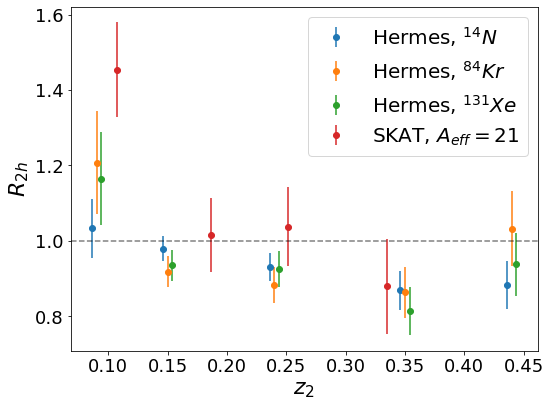

In [13]:
#hermes data:
hermes_y = {}
hermes_ystat = {}
hermes_ysyst = {}
hermes_ytotal = {}

#DATA FROM SELECTIO1 OF http://www-hermes.desy.de/notes/pub/publications.html
hermes_x = {}
hermes_x['Kr'] = [0.09,0.15,0.24,0.35,0.44]
hermes_x['N'] = np.subtract(hermes_x['Kr'],0.004)
hermes_x['Xe'] = np.subtract(hermes_x['Kr'],-0.004)

#nitrogen, atomic number 7
hermes_y['N']     = [1.0324, 0.9781,0.9293,0.8678,0.8822]
hermes_ystat['N'] = [0.0767,0.0268,0.0323,0.0478,0.0601]
hermes_ysyst['N'] = [0.0206,0.0196,0.0186,0.0174,0.0176]
hermes_ytotal['N'] = np.sqrt(np.power(hermes_ystat['N'],2.0)+np.power(hermes_ysyst['N'],2.0))

#krypton, atomic number 36
hermes_y['Kr'] = [1.2072,0.9180,0.8822,0.8631,1.0314]
hermes_ystat['Kr'] = [0.1342,0.0366,0.0452,0.0661,0.0972]
hermes_ysyst['Kr'] =[0.0241,0.0184,0.0176,0.0173,0.0206]
hermes_ytotal['Kr'] = np.sqrt(np.power(hermes_ystat['Kr'],2.0)+np.power(hermes_ysyst['Kr'],2.0))

hermes_y['Xe'] = [1.1648,0.9345,0.9242,0.8128,0.9373]
hermes_ystat['Xe'] = [0.1205,0.0359,0.0433,0.0614,0.0808]
hermes_ysyst['Xe'] = [0.0233,0.0187,0.0185,0.0163,0.0187]
hermes_ytotal['Xe'] = np.sqrt(np.power(hermes_ystat['Xe'],2.0)+np.power(hermes_ysyst['Xe'],2.0))

neutrino_x = [0.10763636363636367, 0.18618181818181817,0.25163636363636366,0.3345454545454546]
neutrino_y = [1.4535664335664338, 1.0148378893833438,  1.0373426573426574, 0.8784361093452003]
neutrino_yerror =[1.5794405594405596, 1.112739987285442, 1.1422377622377624,1.004310235219326]
neutrino_yerror = np.subtract(neutrino_yerror,neutrino_y)

fig = plt.figure(figsize=(8,6))

plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],label='Hermes, $^{14}N$',fmt='o')
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],label='Hermes, $^{84}Kr$',fmt='o')
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],label='Hermes, $^{131}Xe$',fmt='o')
plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,label='SKAT, $A_{eff}=21$',fmt='o')
plt.xlabel('$z_{2}$',fontsize=22)
plt.ylabel('$R_{2h}$',fontsize=22)
plt.axhline(y=1.0,color='black',linestyle='--',alpha=0.5)

plt.tight_layout()
plt.legend(frameon=True)
#plt.savefig('PreviousData.png')
#plt.savefig('PreviousData_R2h.pdf')

plt.show()


Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5


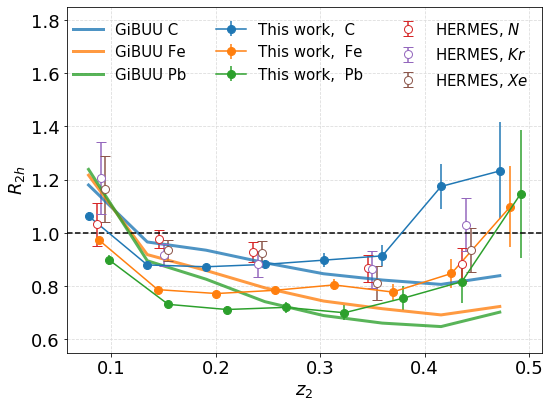

In [14]:
fig = plt.figure(figsize=(8,6))
## getRatio returns:  ratio_conditional,error_conditional,x_conditional

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05,maxz=0.5, variable='h2_z')
    plt.errorbar(x+0.01*i,r,yerr=err,label='This work,  %s'%target,fmt='o-',ms=8) ## 'fmt' is for formatting

    
    #GiBUU
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=0.05,maxz=0.5, applyweight=False, pair_cut = '')
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.9,lw=5)
    plt.plot(x,r,label='GiBUU %s'%target,alpha=0.79,lw=3,color=colors[target])

plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],fmt='o',mfc='white',label='HERMES, $N$',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],fmt='o',mfc='white',label='HERMES, $Kr$',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],fmt='o',mfc='white',label='HERMES, $Xe$',fillstyle=None,ms=8,capsize=5)
#plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,fmt='s',mfc='white',label='Neutrino, $A_{eff}=21$',fillstyle=None,ms=8,capsize=5)

#plt.ylim([0.5,1.5])
#plt.xlim([0.00,0.5])
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=3)

plt.tight_layout()
#plt.savefig('ComparisonWithHermes_Linear.png')
plt.ylim([0.55,1.85]) 

#plt.yscale('log')
#plt.savefig('ComparisonWithHermes_Log.png')
plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')

plt.show()




# Get ratio from MC (null expected). 
**Deviations reflect acceptance differences between solid and liquid target**

In [ ]:
#fig = plt.figure(figsize=(8,6))

#for i,target in enumerate(['C','Fe','Pb']):
#    r, err,x = getRatio(df_mc['%s'%target], df_mc['D'], 
#                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
#                        minz=0.08)
    
#    plt.errorbar(x+0.01,r,yerr=err,label='all pairs,  %s'%target,fmt='o',ms=8)
#    r, err,x = getRatio(df_mc['%s'%target], df_mc['D'], 
#                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
#                        minz=0.08,    pair_cut='and h1_pid>0 and h2_pid<0')
#    plt.errorbar(x+0.02,r,yerr=err,label='$\pi^{+}$, $\pi^{-}$',fmt='o',ms=8)
#    
#    
#    r, err,x = getRatio(df_mc['%s'%target], df_mc['D'], 
#                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
#                        minz=0.08,    pair_cut='and h1_pid<0 and h2_pid>0')
#    plt.errorbar(x+0.03,r,yerr=err,label='$\pi^{-}$, $\pi^{+}$',fmt='o',ms=8)
#    
#plt.ylabel(r'$R_{2h}$',fontsize=22)
#plt.xlabel(r'$z_{2}$',fontsize=22)
#plt.ylim([0.5,1.5])
#plt.legend(frameon=False,loc='best')

# As a function of Pair_pt
pair_pt is a variable, is the transverse momentum of the dipion wrt the virtual photon (the usual pt but this time of the dipion)

Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and abs(h2_pid)==211
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5


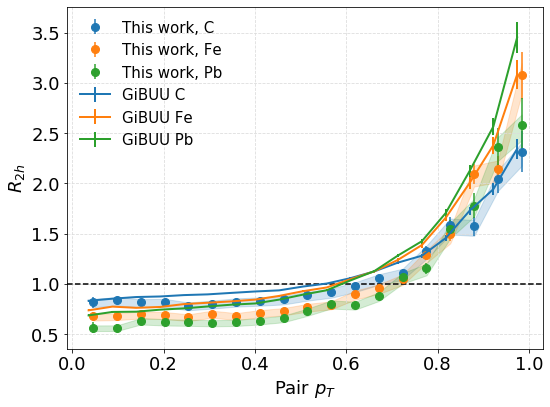

In [15]:
fig = plt.figure(figsize=(8,6))

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target],
                        df_trigger['D_%s_trigger'%target],
                        pair_cut='and abs(h2_pid)==211',minz=0.01,maxz=1.0,nbins=20,variable='pair_pt')
    plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.99,color=colors[target])
    plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
    
for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                        df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                        pair_cut='',minz=0.01,maxz=1.0,nbins=20,variable='pair_pt')    
    plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=8,lw=2)
    
plt.xlabel('Pair $p_{T}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=1)
plt.tight_layout()
plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
#plt.savefig('R2h_Pt.pdf')

# With respect to $\Delta \phi$
'dphi' is a variable , is the difference between the PhiPQ of the trigger hadron and the secondary hadron

Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5


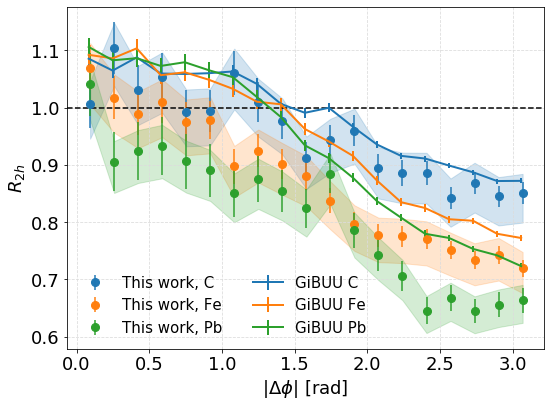

In [16]:
fig = plt.figure(figsize=(8,6))

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.0,maxz=3.14,nbins=20,variable='dphi')
    plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.99,color=colors[target])
    plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
    
for target in ['C','Fe','Pb']:    
    #GiBUU
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                        df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                        minz=0.0,maxz=3.14,nbins=20,variable='dphi')
    plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=8,lw=2)    
    
    
plt.xlabel('$|\Delta\phi|$ [rad]',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

#plt.xlim([0.06,0.5])
#plt.ylim([0.0,2.0])

plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=2)
plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.tight_layout()
#plt.savefig('R2h_DeltaPhi.pdf')

In [ ]:
plt.hist(df['Fe']['dphi'],bins=100,alpha=0.5,density=True,label='Iron') # it's normalized due to the density=True!
plt.hist(df['D_Fe']['dphi'],bins=100,alpha=0.5,density=True,label='Deuterium')
plt.xlabel('dphi')
plt.ylabel('Normalized Entries')
plt.legend()
plt.show()

# As a function of the Dipion mass (GeV)
**the variable is called 'pair_mass'**

Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_z>0.10
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_z>0.10
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_z>0.10
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_z>0.10
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_z>0.10
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_z>0.10


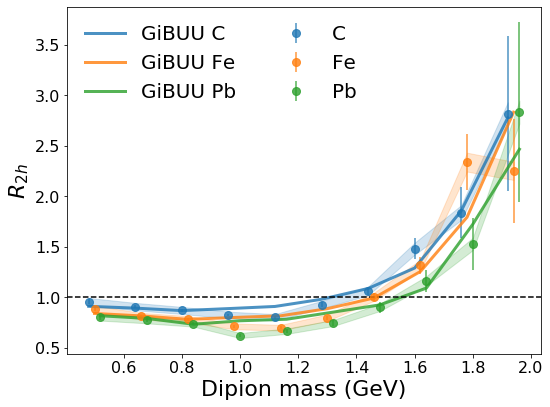

In [17]:
fig = plt.figure(figsize=(8,6))

colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='pair_mass',minz=0.4,maxz=2.0,nbins=11,pair_cut='and h2_z>0.10',applyweight=False
                       )
    plt.errorbar(x+0.02*i,r,yerr=err,label='%s'%target,ms=8,fmt='o',alpha=0.8,color=colors[target])
    plt.fill_between(x+0.02*i,r*1.04,r*0.96, alpha=0.2,color=colors[target])
    
    
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='pair_mass',minz=0.4,maxz=2.0,nbins=11,pair_cut='and h2_z>0.10',applyweight=False
                       )
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)
    plt.plot(x+0.02*i,r,color=colors[target],lw=3,alpha=0.8,label='GiBUU %s'%target)
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.legend(frameon=False,ncol=2,loc='upper left')
plt.xlabel('Dipion mass (GeV)',fontsize=22)
plt.ylabel('$R_{2h}$',fontsize=22)
plt.axhline(y=1.0,color='black',linestyle='--')

#plt.text(0.60, 1.1, 'CLAS \nINTERNAL', fontsize=30)

#plt.ylim([0.0,1.2])
plt.tight_layout()
#plt.savefig('MainResult_withGiBUU_mass.png')
#plt.savefig('MainResult_withGiBUU_mass.pdf')

**From here below not used yet**

In [ ]:
fig = plt.figure(figsize=(8,6))

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                        df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                        pair_cut='and abs(h2_pid)==2212',minz=-1.5,maxz=3.0,nbins=20,variable='h2_rap')
    plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=8,lw=2)

    
for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target],
                        df_trigger['D_%s_trigger'%target],
                       pair_cut='and abs(h2_pid)==2212',minz=-1.5,maxz=3.0,nbins=20,variable='h2_rap')
                       
    plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.99,color=colors[target])
    plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
    
plt.xlabel('proton rapidity',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

#plt.xlim([0.06,0.5])
#plt.ylim([0.0,2.0])

plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=1)


#plt.yscale('log')

plt.tight_layout()
#plt.savefig('TheoryOnly.png')



In [ ]:
fig = plt.figure(figsize=(8,6))

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                        df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                        pair_cut='and abs(h2_pid)==2212 and h2_z>0.1 and h2_rap>-1.5 and h2_rap<-1.0',minz=0.0,maxz=3.14,nbins=20,variable='dphi')
    plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=8,lw=2)
for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target],
                        df_trigger['D_%s_trigger'%target],
                        pair_cut='and abs(h2_pid)==2212 and h2_z>0.1 and h2_rap>-1.5 and h2_rap<-1.0',minz=0.0,maxz=3.14,nbins=20,variable='dphi')
                       
    plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.99,color=colors[target])
    plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
plt.xlabel('$\Delta\phi$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

#plt.xlim([0.06,0.5])
#plt.ylim([0.0,2.0])

plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=1)


#plt.yscale('log')

plt.tight_layout()
plt.savefig('TheoryOnly.png')

In [ ]:
fig = plt.figure(figsize=(8,6))



for i,target in enumerate(['C','Fe','Pb']):
    #data
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='h2_z',minz=0.05,maxz=0.5
                       )
    plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.99,color=colors[target])
    plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
    
    
    #gibuu
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=0.05,maxz=0.5, applyweight=False, pair_cut = ' and abs(h2_pid)==211'
                       )
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.9,lw=5)
    plt.plot(x,r,label='GiBUU %s'%target,alpha=0.79,lw=3,color=colors[target])

#plt.xscale('log')
plt.xlabel('$z_2$',fontsize=22)
plt.ylabel('$R_{2h}$',fontsize=22)
plt.axhline(y=1.0,color='black',linestyle='--')
#plt.ylim([0.0,1.5])
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_z2.png')


#plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],fmt='o',label='Hermes, N',fillstyle=None,ms=8,capsize=5,color='grey')
#plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],fmt='o',label='Hermes, Kr',fillstyle=None,ms=8,capsize=5,color='brown')
#plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],fmt='o',label='Hermes, Xe',fillstyle=None,ms=8,capsize=5,color='darkviolet')
#plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,fmt='s',mfc='white',label='Neutrino, $A_{eff}=21$',fillstyle=None,ms=8,capsize=5)

plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
#plt.text(0.20, 1.2, 'CLAS \nINTERNAL', fontsize=30)

plt.legend(frameon=False,ncol=2,fontsize=15)
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_z2_withHERMES.png')
plt.savefig('MainResult_withGiBUU_z2_withHERMES.pdf')

In [ ]:
fig = plt.figure(figsize=(8,6))

colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'

for i,target in enumerate(['C','Fe','Pb']):
    #data
    
  
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='h2_z',minz=0.07,maxz=0.5,applyweight=False
                       )
    plt.errorbar(np.subtract(x,0*0.0025),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8,color=colors[target])

   
plt.xlabel('$z_2$',fontsize=22)
plt.ylabel('$R_{2h}$',fontsize=22)
plt.axhline(y=1.0,color='black',linestyle='--')
#plt.ylim([0.0,1.5])
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_z2.png')


plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)

plt.legend(frameon=False,ncol=3,fontsize=15)
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_z2_withHERMES.png')
plt.savefig('MainResult_withGiBUU_z2_withHERMES.pdf')